## Table of Content:
* [Data Preparation & Visualisation](#data-prep-viz)
* [Machine Learning](#ml)

In [1]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from skimpy import skim

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Preparation & Visualisation <a class="anchor" id="data-prep-viz"></a>

## Helper Functions

In [3]:
NUMPY_INTS = [np.dtypes.Float64DType, np.dtypes.Float32DType, np.dtypes.Int64DType, np.dtypes.Int32DType]

def fetch_data(url, out_file):
  res = requests.get(url)
  if res.content:
    with open(out_file, "w") as csv_file:
      writer = csv.writer(csv_file)
      content = res.content.decode("utf-8").split("\n")
      for line in content:
        line = [entry.replace('"', '').replace('\r', '') for entry in line.split(",")]
        writer.writerow(line)

# Returns a cleaned up dataframe
def do_basic_cleanup(df, drop_cols):
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    return df

# returns a series with Value counts, where ....
# https://www.kaggle.com/code/parulpandey/five-ways-to-use-value-counts
def value_counts(df):
    res = []
    for col in df.columns:
      preliminary_res = df[col].value_counts()
      if preliminary_res.size > 20:
        if type(df[col].dtype) in NUMPY_INTS:
          preliminary_res = df[col].value_counts(bins=10)
          preliminary_res.name = preliminary_res.name + "- BINNED"
        else:
          preliminary_res = df[col].value_counts(normalize=True)  
          preliminary_res.name = preliminary_res.name + "- NORMALIZED"
      res.append(preliminary_res)
    return res

def cast_cols_to_str(df, cols):
    for col in cols:
      df[col] = df[col].astype(str)


In [213]:
# Source: https://data.cso.ie/table/ASA02
fetch_data("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ASA02/CSV/1.0/en", "irl_tourism.csv")

In [437]:
df = pd.read_csv("irl_tourism.csv", on_bad_lines='warn')
df.head(10)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02293V02763,Direction,C03042V03675,Route,UNIT,VALUE
0,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,-,All routes of travel,Thousand,12902.2
1,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,01,Cross channel,Thousand,6113.0
2,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,02,Continental Europe,Thousand,5652.6
3,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,03,Transatlantic,Thousand,914.5
4,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,04,Other,Thousand,222.1
5,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,-,All routes of travel,Thousand,12920.2
6,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,01,Cross channel,Thousand,6132.4
7,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,02,Continental Europe,Thousand,5643.3
8,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,03,Transatlantic,Thousand,924.3
9,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,04,Other,Thousand,220.3


In [215]:
df = do_basic_cleanup(df, ["STATISTIC", "STATISTIC Label", "TLIST(A1)", "C02293V02763", "C03042V03675", "UNIT"])

df = df.dropna()
df = df.astype({"year": int})
df.head()

,year,direction,route,value
0,2010,Arrivals,All routes of travel,12902.2
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1


,year,direction,route,value
135,2023,Departures,All routes of travel,20626.2
136,2023,Departures,Cross channel,7216.1
137,2023,Departures,Continental Europe,10485.0
138,2023,Departures,Transatlantic,2139.5
139,2023,Departures,Other,785.6


In [216]:
#df.apply(lambda col: col.value_counts(), axis=1)
#skim(df)
df['value'].value_counts(bins=7)
print(type(df['value'].dtype))

(128.722, 3074.486]       64
(5999.771, 8925.057]      33
(3074.486, 5999.771]      12
(11850.343, 14775.629]    10
(17700.914, 20626.2]       8
(8925.057, 11850.343]      7
(14775.629, 17700.914]     6
Name: count, dtype: int64

<class 'numpy.dtypes.Float64DType'>


## Looking at arrivals from different destinations 

In [217]:
arrivals = df[(df['direction'] == 'Arrivals') & (df['route'] != 'All routes of travel')]
departures = df[(df['direction'] == 'Departures') & (df['route'] != 'All routes of travel')]

In [218]:
arrivals.head()

,year,direction,route,value
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1
11,2011,Arrivals,Cross channel,6102.5


Text(0.5, 1.0, 'Number of Arrivals Into Ireland')

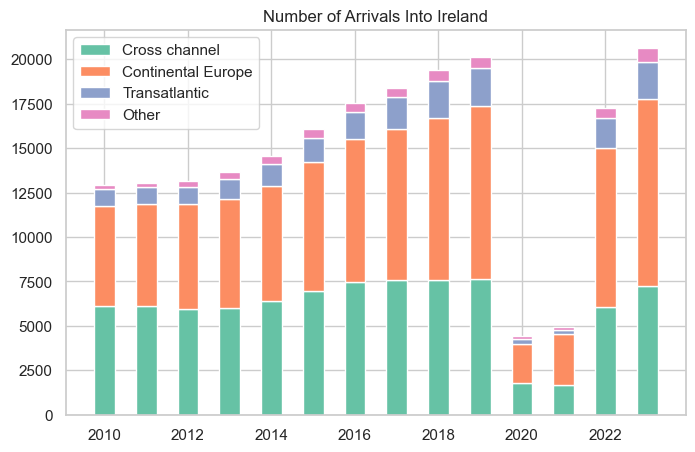

In [219]:
#sns.set_theme(style="whitegrid")

#ax = sns.barplot(data=arrivals, x="year", y="value", hue="route", palette='flare')

x = arrivals['year'].unique()
routes = arrivals['route'].unique()
bottom = np.zeros(len(x))
palette = sns.color_palette("Set2")

_, ax= plt.subplots(figsize=(8, 5))
width = 0.5

#for year in x:
for i, route in enumerate(routes):
   data = arrivals[arrivals['route'] == route]['value']
   _ = ax.bar(x, data, width, label=route, bottom=bottom, color=palette[i])
   bottom += data.to_numpy()

ax.set_title("Number of Arrivals Into Ireland")
ax.legend(loc="upper left")


## Explore percent change Year over Year

In [222]:
arrivals_cols = arrivals.set_index(['year', 'route'])['value'].unstack()
raw_cols = arrivals_cols.columns
new_cols = []
for c in arrivals_cols.columns.to_numpy():
    new_col = "ptc_ch_" + c.lower().replace(" ", "_")
    new_cols.append(new_col)
    arrivals_cols[new_col] = round(arrivals_cols[c].pct_change() * 100, 2)
arrivals_cols = arrivals_cols.drop(columns=raw_cols)
arrivals_cols = arrivals_cols.reset_index()
arrivals_cols.head()

route,year,ptc_ch_continental_europe,ptc_ch_cross_channel,ptc_ch_other,ptc_ch_transatlantic
0,2010,NaN,NaN,NaN,NaN
1,2011,2.30,-0.17,4.55,1.97
2,2012,2.38,-2.82,43.84,2.68
3,2013,3.72,1.44,14.85,14.16
4,2014,5.09,6.75,12.96,13.31


In [223]:
a = arrivals_cols.melt(id_vars=['year'], value_vars=new_cols)
a.head()

,year,route,value
0,2010,ptc_ch_continental_europe,NaN
1,2011,ptc_ch_continental_europe,2.30
2,2012,ptc_ch_continental_europe,2.38
3,2013,ptc_ch_continental_europe,3.72
4,2014,ptc_ch_continental_europe,5.09


<Axes: xlabel='year', ylabel='value'>

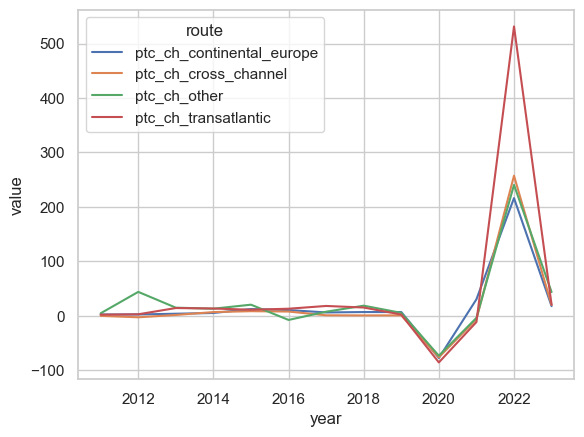

In [398]:
sns.lineplot(data=a, x="year", y="value", hue="route")

## Flights to Ireland from other international airports
1. Data from https://ec.europa.eu/eurostat/web/transport/data/database
2. https://ec.europa.eu/eurostat/databrowser/explore/all/transp?lang=en&subtheme=avia.avia_pa.avia_par&display=list&sort=category&extractionId=avia_par_ie
3. Explanatory notes on the data https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en
4. API https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true

|Dimension	| Agency : Code list | Values |
| --- | --- | --- |
|FREQ | Time frequency	ESTAT : FREQ | Annual, Quarterly, Monthly ||
|UNIT | Unit of measure	ESTAT : UNIT | Passenger, Flights, Seats and berths||
|TRA_MEAS | Traffic and transport measurement	ESTAT : TRA_MEAS ||
|AIRP_PR | Airport pairs (routes)	ESTAT : AIRP_PR ||
|OBS_FLAG | Observation status (Flag)	ESTAT : OBS_FLAG ||

In [226]:
#IRL_AIRPORT_PASS_TRAVEL = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true"
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=SDMX-CSV&lang=en&label=both
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=TSV
# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

### ONLY REPLAY IF DATASET IS MISSING< IT IS VERY BIG
fetch_data("https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/avia_par_ie/1.0?compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name", 
           "flights.csv")

In [24]:
# Cannot commit the dataset to GitHub, as it is beyond the file size allowd by GH
# Replay the previous step to generate the dataset
# low_memory=False due to mixed datatypes
flights = pd.read_csv("flights.csv", low_memory=False)

In [25]:
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)
#flights.columns
flights.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,tra_meas,Traffic and transport measurement,airp_pr,Airport pairs (routes),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag)
0,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2012,NaN,256.0,NaN,NaN,NaN
1,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2013,NaN,248.0,NaN,NaN,NaN
2,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CH_LSZH,CORK airport - ZURICH airport,2019,NaN,213.0,NaN,NaN,NaN
3,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2003,NaN,296.0,NaN,NaN,NaN
4,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2004,NaN,557.0,NaN,NaN,NaN


In [26]:
# Remove column repetitions
flights = do_basic_cleanup(flights, ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", 
                                     "freq", 'unit', 'Time', 'Observation value', 'Observation status (Flag)', 'OBS_FLAG', 'tra_meas', 'Airport pairs (routes)'])

In [27]:
flights.dtypes
value_counts(flights)

time_frequency                        object
unit_of_measure                       object
traffic_and_transport_measurement     object
airp_pr                               object
time_period                           object
obs_value                            float64
dtype: object

[time_frequency
 Monthly      370798
 Quarterly    126827
 Annual        31623
 Name: count, dtype: int64,
 unit_of_measure
 Passenger           270142
 Seats and berths    129621
 Flight              129485
 Name: count, dtype: int64,
 traffic_and_transport_measurement
 Passengers carried                               46912
 Passengers carried (arrival)                     46826
 Passengers carried (departures)                  46783
 Passengers on board                              43279
 Passengers seats available                       43279
 Commercial passenger air flights                 43228
 Passengers on board (arrivals)                   43188
 Passengers seats available (arrivals)            43188
 Passengers on board (departures)                 43154
 Passengers seats available (departures)          43154
 Commercial passenger air flights (arrivals)      43143
 Commercial passenger air flights (departures)    43114
 Name: count, dtype: int64,
 airp_pr
 IE_EIDW_UK_EGSS    

In [28]:
flights_m = flights[flights['time_frequency'] == 'Monthly']

In [29]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True
flights_m[['year', 'month']] = flights_m['time_period'].str.split('-', expand=True)
flights_m = flights_m.drop(columns=['time_period', 'time_frequency'])

In [30]:
flights_m.head()

,unit_of_measure,traffic_and_transport_measurement,airp_pr,obs_value,year,month
31623,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,6.0,2012,03
31624,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,04
31625,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,05
31626,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,06
31627,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,07


In [31]:
#flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)
#flights_m[['domestic_airpot', 'international_airport']] 
flights_m['airp_pr'].apply(lambda x: len(x)).value_counts()

# Same lengths, so we can attempt to split the pairs
flights_m['domestic_airpot']  = flights_m['airp_pr'].apply(lambda x: x[:7])
flights_m['international_airport'] = flights_m['airp_pr'].apply(lambda x: x[8:15])
flights_m.drop(columns=['airp_pr'], inplace=True)

flights_m['domestic_airpot'].value_counts()
flights_m['international_airport'].value_counts()

airp_pr
15    370798
Name: count, dtype: int64

domestic_airpot
IE_EIDW    217466
IE_EICK     60768
IE_EINN     54716
IE_EIKN     22844
IE_EIKY     12016
IE_EICM      2988
Name: count, dtype: int64

international_airport
UK_EGSS    14119
UK_EGCC    12208
UK_EGKK    10485
UK_EGBB    10410
ES_GCRR     9855
           ...  
US_KDFW       84
UK_EGAA       66
ZZ_ZZZZ       65
EL_LGIR       54
UK_EGHD       36
Name: count, Length: 141, dtype: int64

In [32]:
flights_m.head()

,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport
31623,Flight,Commercial passenger air flights,6.0,2012,03,IE_EICK,BE_EBBR
31624,Flight,Commercial passenger air flights,26.0,2012,04,IE_EICK,BE_EBBR
31625,Flight,Commercial passenger air flights,26.0,2012,05,IE_EICK,BE_EBBR
31626,Flight,Commercial passenger air flights,26.0,2012,06,IE_EICK,BE_EBBR
31627,Flight,Commercial passenger air flights,26.0,2012,07,IE_EICK,BE_EBBR


In [33]:
# res = requests.get('https://gist.githubusercontent.com/ssskip/5a94bfcd2835bf1dea52/raw/3b2e5355eb49336f0c6bc0060c05d927c2d1e004/ISO3166-1.alpha2.json')
# take this maybe?

res = requests.get('https://gist.githubusercontent.com/fogonwater/bc2b98baeb2aa16b5e6fbc1cf3d7d545/raw/6fd2951260d8f171181a45d2f09ee8b2c7767330/countries.json')
country_codes = json.loads(res.content.decode("utf-8"))

In [34]:
country_codes

{'AD': {'continent_code': 'EU',
  'continent_name': 'Europe',
  'country_code2': 'AD',
  'country_code3': 'AND',
  'country_name': 'Andorra',
  'country_name_full': 'Principality of Andorra',
  'iso3': '020'},
 'AE': {'continent_code': 'AS',
  'continent_name': 'Asia',
  'country_code2': 'AE',
  'country_code3': 'ARE',
  'country_name': 'United Arab Emirates',
  'country_name_full': 'United Arab Emirates',
  'iso3': '784'},
 'AF': {'continent_code': 'AS',
  'continent_name': 'Asia',
  'country_code2': 'AF',
  'country_code3': 'AFG',
  'country_name': 'Afghanistan',
  'country_name_full': 'Islamic Republic of Afghanistan',
  'iso3': '004'},
 'AG': {'continent_code': 'NA',
  'continent_name': 'North America',
  'country_code2': 'AG',
  'country_code3': 'ATG',
  'country_name': 'Antigua and Barbuda',
  'country_name_full': 'Antigua and Barbuda',
  'iso3': '028'},
 'AI': {'continent_code': 'NA',
  'continent_name': 'North America',
  'country_code2': 'AI',
  'country_code3': 'AIA',
  'coun

In [35]:
# According to https://www.destatis.de/Europa/EN/Country/Country-Codes.html Greece is assigned GR country code, however, on Eurostate it is EL
# In our countries mapping, we only have GR, so we can add an entry for Greece in our `country_codes`
# GB (Eurostat: UK)
# Add aliases for EL and UK, which are actually GR and GB

country_codes['EL'] = {'continent_code': 'EU',
  'continent_name': 'Europe',
  'country_code2': 'GR',
  'country_code3': 'GRC',
  'country_name': 'Greece'}

country_codes['UK'] = {   "continent_code": "EU",
    "continent_name": "Europe",
    "country_code2": "GB",
    "country_code3": "GBR",
    "country_name": "United Kingdom of Great Britain & Northern Ireland",
    "country_name_full": "United Kingdom of Great Britain & Northern Ireland",
    "iso3": "826"
  }

In [36]:
flights_m['country_code'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['country_name'] if x[0:2] in country_codes else x[0:2])

flights_m['continent_name'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['continent_name'] if x[0:2] in country_codes else x[0:2])

flights_m = flights_m.loc[(flights_m['continent_name'] == 'Europe')]
flights_m['obs_value'] = flights_m['obs_value'].astype(int)

#flights_m = flights_m.drop(columns=[''])

In [37]:
passengers_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & ((flights_m['traffic_and_transport_measurement'] == 'Passengers on board (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (departures)'))]
seats_available_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Seats and berths') & ((flights_m['traffic_and_transport_measurement'] == 'Passengers seats available (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Passengers seats available (departures)'))]
flights_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & ((flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (departures)'))]

#flights_pass_q = flights_pass_q.drop(columns=['time_frequency', 'unit_of_measure', 'traffic_and_transport_measurement', 'tra_meas', 'obs_flag'])
# flights_pass_q.head()
# flights_pass_q.size
# https://store.icao.int/en/location-indicators-doc-7910 to map to 



<Axes: xlabel='month', ylabel='obs_value'>

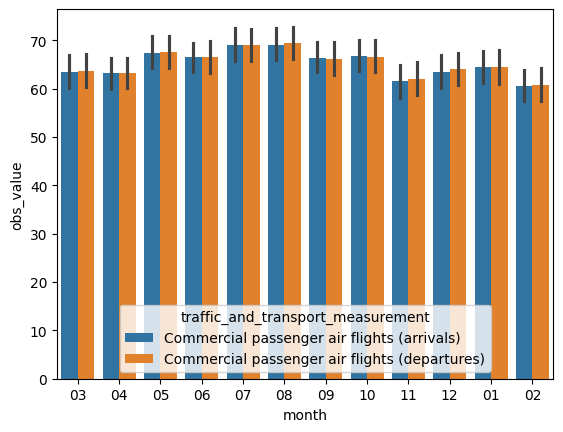

In [38]:
sns.barplot(data=flights_month, x='month', y='obs_value', hue='traffic_and_transport_measurement')

In [39]:
passengers_month.rename(columns={"obs_value": "num_passangers"}, inplace=True)
seats_available_month.rename(columns={"obs_value": "total_capacity"}, inplace=True)
flights_month.rename(columns={"obs_value": "num_flights"}, inplace=True)


In [40]:
component_dfs = [passengers_month, flights_month, seats_available_month]

for df in component_dfs:
  df.drop(columns=['unit_of_measure', 'continent_name'], inplace=True)
  df['traffic_and_transport_measurement'] = df["traffic_and_transport_measurement"].apply(lambda x: 'arrivals' if 'arrivals' in x else 'departures')
  df.rename(columns={"traffic_and_transport_measurement": "direction"}, inplace=True)
  
  # Check the Arrivals / Departures transform did not result in losing any values
  df['direction'].isna().value_counts()

direction
False    53702
Name: count, dtype: int64

direction
False    53667
Name: count, dtype: int64

direction
False    53702
Name: count, dtype: int64

In [41]:
for df in component_dfs:
  df.head()
  df.tail()

for df in component_dfs:
  df.shape

,direction,num_passangers,year,month,domestic_airpot,international_airport,country_code
152840,arrivals,271,2012,03,IE_EICK,BE_EBBR,Belgium
152841,arrivals,1346,2012,04,IE_EICK,BE_EBBR,Belgium
152842,arrivals,1377,2012,05,IE_EICK,BE_EBBR,Belgium
152843,arrivals,1082,2012,06,IE_EICK,BE_EBBR,Belgium
152844,arrivals,1550,2012,07,IE_EICK,BE_EBBR,Belgium


,direction,num_passangers,year,month,domestic_airpot,international_airport,country_code
212547,departures,11543,2023,06,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
212548,departures,11749,2023,07,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
212549,departures,12924,2023,08,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
212550,departures,10089,2023,09,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
212551,departures,10308,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


,direction,num_flights,year,month,domestic_airpot,international_airport,country_code
61956,arrivals,3,2012,03,IE_EICK,BE_EBBR,Belgium
61957,arrivals,13,2012,04,IE_EICK,BE_EBBR,Belgium
61958,arrivals,13,2012,05,IE_EICK,BE_EBBR,Belgium
61959,arrivals,13,2012,06,IE_EICK,BE_EBBR,Belgium
61960,arrivals,13,2012,07,IE_EICK,BE_EBBR,Belgium


,direction,num_flights,year,month,domestic_airpot,international_airport,country_code
121593,departures,73,2023,06,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
121594,departures,76,2023,07,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
121595,departures,74,2023,08,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
121596,departures,73,2023,09,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
121597,departures,75,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


,direction,total_capacity,year,month,domestic_airpot,international_airport,country_code
341842,arrivals,522,2012,03,IE_EICK,BE_EBBR,Belgium
341843,arrivals,2262,2012,04,IE_EICK,BE_EBBR,Belgium
341844,arrivals,2262,2012,05,IE_EICK,BE_EBBR,Belgium
341845,arrivals,2262,2012,06,IE_EICK,BE_EBBR,Belgium
341846,arrivals,2262,2012,07,IE_EICK,BE_EBBR,Belgium


,direction,total_capacity,year,month,domestic_airpot,international_airport,country_code
401549,departures,14017,2023,06,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
401550,departures,14579,2023,07,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
401551,departures,14183,2023,08,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
401552,departures,14051,2023,09,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...
401553,departures,14411,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


(53702, 7)

(53667, 7)

(53702, 7)

In [24]:
shapes = {
    'passengers_arr_month': passengers_month.shape[0],
    'seats_available_arr_month': seats_available_month.shape[0],
    'flights_arr_month': flights_month.shape[0],
}
shapes

{'passengers_arr_month': 53702,
 'seats_available_arr_month': 53702,
 'flights_arr_month': 53667}

In [43]:
# Since the dataframes differ in size, do an outer join to ensure we have all values for now
keys = ['year', 'month', 'direction', 'domestic_airpot', 'international_airport', 'country_code']
merged_df = passengers_month.merge(seats_available_month, on=keys, how='outer')
merged_df = merged_df.merge(flights_month, on=keys, how='outer')


In [44]:
merged_df = merged_df.reindex(columns=['year','month', 'direction',	'domestic_airpot','international_airport', 'country_code', 
                                       'num_passangers','total_capacity','num_flights'])


In [46]:
merged_df.shape

(53702, 9)

In [47]:
merged_df['pct_occupancy'] = merged_df['num_passangers'] / merged_df['total_capacity']
merged_df['pct_occupancy'].isna().value_counts()
merged_df.loc[((merged_df['pct_occupancy'] == np.inf) | (merged_df['pct_occupancy'] == np.inf))].pct_occupancy.value_counts()

# TODO: merged_df SORT!!!!!!!!!!!!


pct_occupancy
False    53669
True        33
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

In [48]:
merged_df.replace([np.inf, -np.inf, 0], np.nan, inplace=True)

In [49]:
merged_df.shape
merged_df.describe()

(53702, 10)

,num_passangers,total_capacity,num_flights,pct_occupancy
count,53662.000000,53669.000000,53667.000000,53662.000000
mean,8051.954847,10621.126144,65.367023,0.759635
std,10294.330551,13426.710245,80.270933,0.153810
min,1.000000,5.000000,1.000000,0.013228
25%,2373.250000,3258.000000,22.000000,0.678786
50%,4736.000000,5867.000000,37.000000,0.780000
75%,9193.750000,11738.000000,75.000000,0.873206
max,100056.000000,134374.000000,1123.000000,1.066138


In [50]:
arrivals = merged_df.loc[(merged_df['direction'] == 'arrivals')]
departures = merged_df.loc[(merged_df['direction'] == 'departures')]

,year,month,direction,domestic_airpot,international_airport,country_code,num_passangers,total_capacity,num_flights,pct_occupancy
26865,2012,03,departures,IE_EICK,BE_EBBR,Belgium,307.0,522.0,3.0,0.588123
26866,2012,04,departures,IE_EICK,BE_EBBR,Belgium,1321.0,2262.0,13.0,0.583996
26867,2012,05,departures,IE_EICK,BE_EBBR,Belgium,1344.0,2262.0,13.0,0.594164
26868,2012,06,departures,IE_EICK,BE_EBBR,Belgium,1152.0,2262.0,13.0,0.509284
26869,2012,07,departures,IE_EICK,BE_EBBR,Belgium,1383.0,2262.0,13.0,0.611406
...,...,...,...,...,...,...,...,...,...,...
53697,2023,06,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,11543.0,14017.0,73.0,0.823500
53698,2023,07,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,11749.0,14579.0,76.0,0.805885
53699,2023,08,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,12924.0,14183.0,74.0,0.911232
53700,2023,09,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,10089.0,14051.0,73.0,0.718027


<Axes: xlabel='pct_occupancy', ylabel='Count'>

<Axes: xlabel='pct_occupancy', ylabel='Count'>

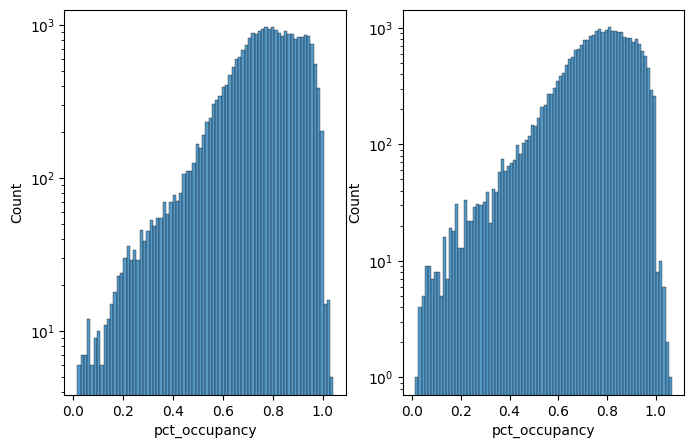

In [60]:
_, ax = plt.subplots(1, 2, figsize=(8, 5))
sns.histplot(data=arrivals, x='pct_occupancy', ax=ax[0])
ax[0].set_yscale('log')

sns.histplot(data=departures, x='pct_occupancy', ax=ax[1])
ax[1].set_yscale('log')


In [53]:
merged_df.head(10)
merged_df.tail(10)

,year,month,direction,domestic_airpot,international_airport,country_code,num_passangers,total_capacity,num_flights,pct_occupancy
0,2012,03,arrivals,IE_EICK,BE_EBBR,Belgium,271.0,522.0,3.0,0.519157
1,2012,04,arrivals,IE_EICK,BE_EBBR,Belgium,1346.0,2262.0,13.0,0.595049
2,2012,05,arrivals,IE_EICK,BE_EBBR,Belgium,1377.0,2262.0,13.0,0.608753
3,2012,06,arrivals,IE_EICK,BE_EBBR,Belgium,1082.0,2262.0,13.0,0.478338
4,2012,07,arrivals,IE_EICK,BE_EBBR,Belgium,1550.0,2262.0,13.0,0.685234
5,2012,08,arrivals,IE_EICK,BE_EBBR,Belgium,1456.0,2436.0,14.0,0.597701
6,2012,09,arrivals,IE_EICK,BE_EBBR,Belgium,1004.0,2088.0,12.0,0.480843
7,2012,10,arrivals,IE_EICK,BE_EBBR,Belgium,1515.0,2610.0,15.0,0.580460
8,2012,11,arrivals,IE_EICK,BE_EBBR,Belgium,1345.0,2784.0,16.0,0.483118
9,2012,12,arrivals,IE_EICK,BE_EBBR,Belgium,1597.0,2784.0,16.0,0.573635


,year,month,direction,domestic_airpot,international_airport,country_code,num_passangers,total_capacity,num_flights,pct_occupancy
53692,2023,01,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,8317.0,12354.0,65.0,0.673223
53693,2023,02,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,7892.0,10645.0,56.0,0.741381
53694,2023,03,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,8594.0,12398.0,65.0,0.693176
53695,2023,04,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,11266.0,14994.0,78.0,0.751367
53696,2023,05,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,10116.0,15172.0,79.0,0.666755
53697,2023,06,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,11543.0,14017.0,73.0,0.823500
53698,2023,07,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,11749.0,14579.0,76.0,0.805885
53699,2023,08,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,12924.0,14183.0,74.0,0.911232
53700,2023,09,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,10089.0,14051.0,73.0,0.718027
53701,2023,10,departures,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,10308.0,14411.0,75.0,0.715287


In [60]:
grouped_df = merged_df.groupby(['international_airport', 'country_code'], as_index=False).sum().sort_values(['num_passangers_arrivals'], ascending=False).drop(axis=0, )
grouped_df

,international_airport,country_code,year,month,domestic_airpot,num_passangers_arrivals,num_passangers_departures,total_capacity_arrivals,total_capacity_departures,num_flights_arrivals,num_flights_departures,pct_occupancy_arrivals,pct_occupancy_departures
102,UK_EGLL,United Kingdom of Great Britain & Northern Ire...,2003200320032003200320032003200320032003200320...,0102030405060708091011120102030405060708091011...,IE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_E...,23162710.0,23751297.0,31693143.0,31733073.0,177668.0,177826.0,517.598048,531.370710
113,UK_EGSS,United Kingdom of Great Britain & Northern Ire...,2003200320032003200320032003200320032003200320...,0102030405060708091011120102030405060708091011...,IE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_E...,15942195.0,15823619.0,20247768.0,20184936.0,109015.0,108795.0,870.058514,874.110034
100,UK_EGKK,United Kingdom of Great Britain & Northern Ire...,2004200420042004200420042004200420042005200520...,0405060708091011120102030405060708091011120102...,IE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_E...,12942452.0,12761219.0,16931396.0,16934382.0,96925.0,96926.0,639.112156,636.022021
92,UK_EGCC,United Kingdom of Great Britain & Northern Ire...,2003200320032003200320032003200320032003200320...,0102030405060708091011120102030405060708091011...,IE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_E...,9337340.0,9392559.0,13055405.0,13055341.0,91129.0,91087.0,682.992660,688.409271
71,NL_EHAM,Netherlands,2003200320032003200320032003200320032003200320...,0102030405060708091011120102030405060708091011...,IE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_E...,8287082.0,8295084.0,10822372.0,10865638.0,64664.0,64720.0,370.648089,369.909567
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,DE_EDJA,Germany,2014201420142014201420142014201520152015201520...,04050607080910030405060708091011,IE_EINNIE_EINNIE_EINNIE_EINNIE_EINNIE_EINNIE_E...,25175.0,24294.0,35343.0,35154.0,187.0,186.0,11.490995,10.920724
86,RO_LRCL,Romania,202120212021202120212021202120212021202120212021,010203040506070809101112,IE_EIDWIE_EIDWIE_EIDWIE_EIDWIE_EIDWIE_EIDWIE_E...,21173.0,19781.0,31738.0,30839.0,171.0,166.0,7.946577,7.755477
40,FR_LFML,France,2023202320232023202320232023202320232023,01020304050607080910,IE_EINNIE_EINNIE_EINNIE_EINNIE_EINNIE_EINNIE_E...,11858.0,11932.0,16466.0,16450.0,87.0,86.0,7.173425,7.264339
20,EL_LGIR,Greece,200320032003200320032003,050607080910,IE_EICKIE_EICKIE_EICKIE_EICKIE_EICKIE_EICK,10185.0,10099.0,10802.0,10624.0,58.0,57.0,5.598799,5.596324


<Figure size 960x480 with 0 Axes>

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_94604/1767259874.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = a.set_xticklabels(a.get_xticklabels(), rotation=35)


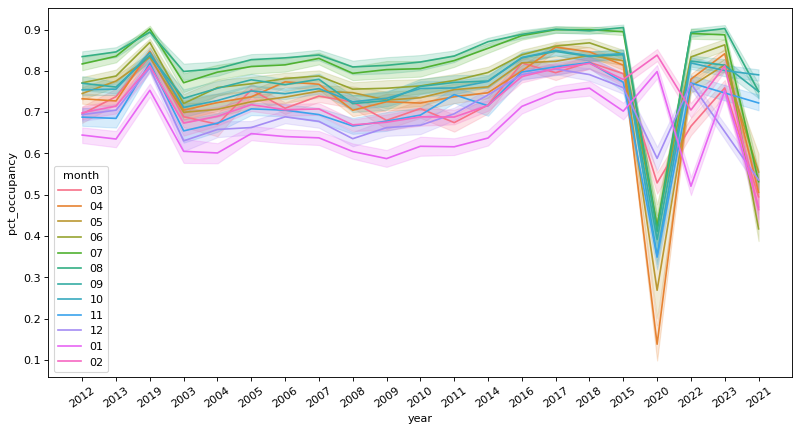

In [64]:
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)

a = sns.lineplot(data=merged_df, x='year', y='pct_occupancy', hue='month')
_ = a.set_xticklabels(a.get_xticklabels(), rotation=35)

## Preprocessing

In [ ]:
import numpy as np
from sklearn.preprocessing import scale, StandardScaler

# Generating example data with different scales
data = np.array([[1.0, 20.0, 300.0],
                 [4.0, 50.0, 600.0],
                 [7.0, 80.0, 900.0]])

print("Original data:\n", data)

# Method 1: Scaling using the scale function
scaled_data = scale(data)
print("\nScaled data using scale function:\n", scaled_data)

# Method 2: Using StandardScaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)
print("\nStandardized data using StandardScaler:\n", standardized_data)

## Machine Learning <a class="anchor" id="ml"></a>


In [ ]:
# Model building

# instantiate an object of class SVC()
# note that we are using cost C=1
model = SVC(C = 1)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

print(y_pred)

In [62]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = load_wine(return_X_y=True, as_frame=True)
scaler = StandardScaler().set_output(transform="pandas")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
scaled_X_train = scaler.fit_transform(X_train)

<Axes: xlabel='proline', ylabel='hue'>

Text(0.5, 1.0, 'KNN without scaling')

<Axes: xlabel='proline', ylabel='hue'>

Text(0.5, 0, 'scaled proline')

Text(0, 0.5, 'scaled hue')

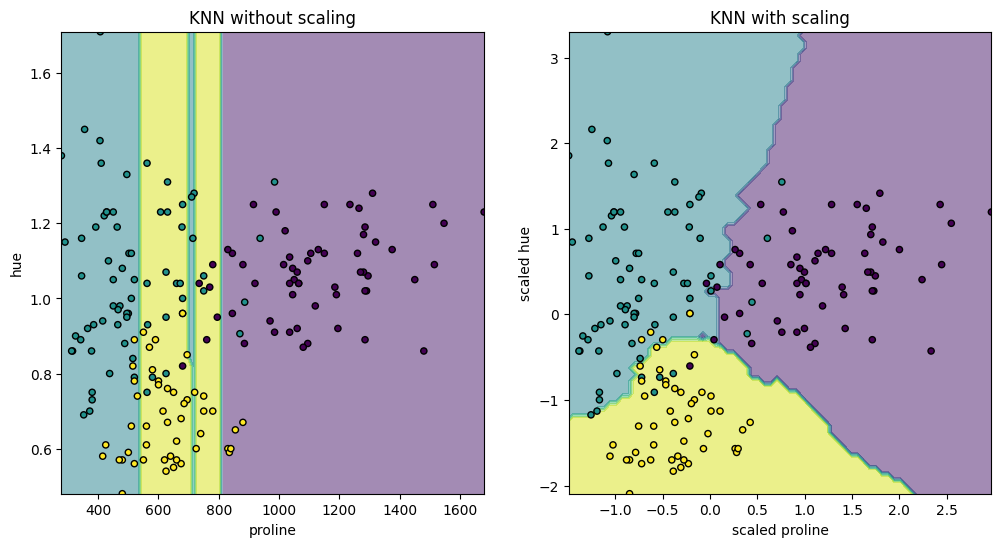

In [63]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

X_plot = X[["proline", "hue"]]
X_plot_scaled = scaler.fit_transform(X_plot)
clf = KNeighborsClassifier(n_neighbors=20)


def fit_and_plot_model(X_plot, y, clf, ax):
    clf.fit(X_plot, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    disp.ax_.scatter(X_plot["proline"], X_plot["hue"], c=y, s=20, edgecolor="k")
    disp.ax_.set_xlim((X_plot["proline"].min(), X_plot["proline"].max()))
    disp.ax_.set_ylim((X_plot["hue"].min(), X_plot["hue"].max()))
    return disp.ax_


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fit_and_plot_model(X_plot, y, clf, ax1)
ax1.set_title("KNN without scaling")

fit_and_plot_model(X_plot_scaled, y, clf, ax2)
ax2.set_xlabel("scaled proline")
ax2.set_ylabel("scaled hue")
_ = ax2.set_title("KNN with scaling")